# Problème n°2: PointNet

Certains jeux de données impliquent des nuages de points dans un espace 3D. Penser par exemple à un ensemble de mesures lidar : chaque tir permet de renseigner les coordonnées d'un des points de l'objet ciblé.
Une tâche intéressante consiste à classer chacun des points du nuage en fonction de l'objet auquel il appartient. Cette tâche est considérée comme une variante de la segmentation sémantique d'images.

Ce problème introduit à une méthode directe de segmentation d'un nuage par deep learning. Elle est basée sur une architecture particulière appelée PointNet. \
Dans la première partie, on présente un jeu de données (synthétisé à la volée) impliquant des nuages de points.
Dans la seconde partie, on explore la structure et les propriétés de PointNet. Dans la troisième, on l'entraîne et dans la dernière partie, on charge les poids d'une version améliorée de PointNet (PointNet++) pour comparaison.

La cellule suivante permet les imports nécessaires:

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import matplotlib.pyplot as plt
import os
! pip install einops
! git clone https://github.com/cutiepie1011/exam_2025.git
! cp exam_2025/utils/utils_probleme2.py .
from utils_probleme2 import gen_pointcloud, plot_triplets

Cloning into 'exam_2025'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 79 (delta 14), reused 6 (delta 6), pack-reused 54 (from 1)
Receiving objects: 100% (79/79), 1.87 MiB | 18.42 MiB/s, done.
Resolving deltas: 100% (26/26), done.


## Partie I : un exemple de PointCLoud data

Pour construire le jeu de données, on simule un terrain couvert de deux types de bâtiments : des immeubles de forme rectangulaire aux toits plats et des igloos (dômes). Pour créer les nuages, on échantillonne les surfaces vues du ciel (les murs des bâtiments rectangulaires ne sont pas échantillonnées), en favorisant les zones d'altitude non nulles.
Le but est de distinguer les igloos du reste (sol et toits des bâtiments). Il s'agit donc d'une segmentation binaire.

0


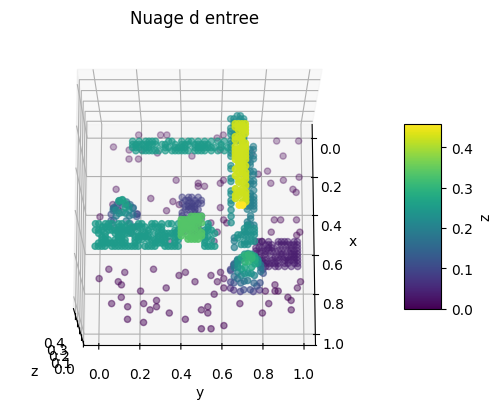

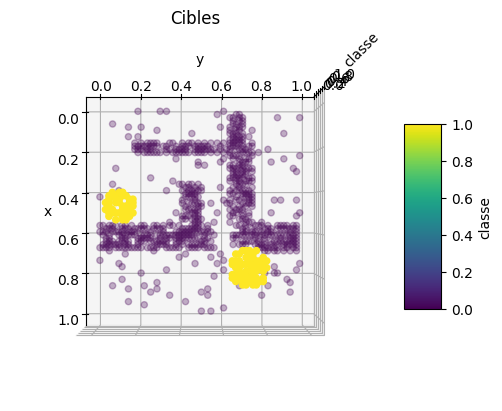

1


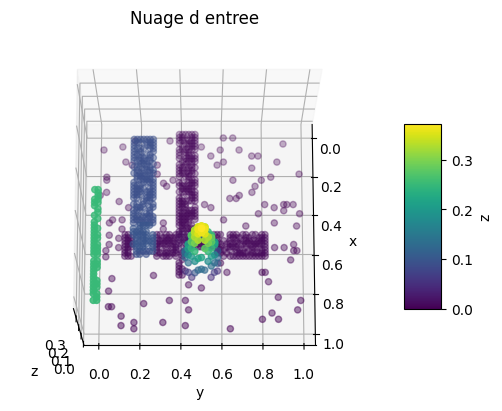

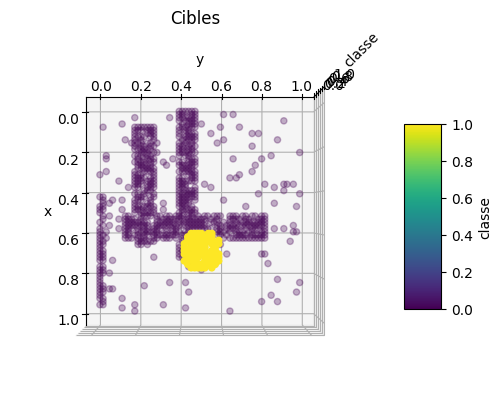

2


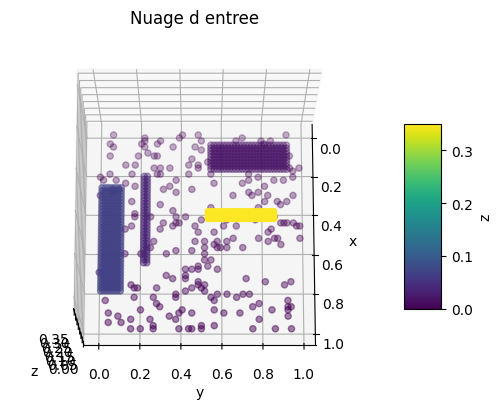

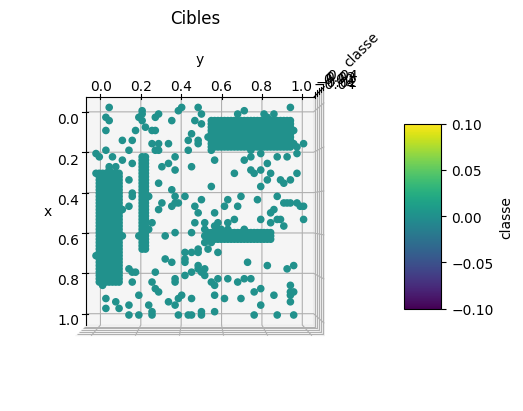

3


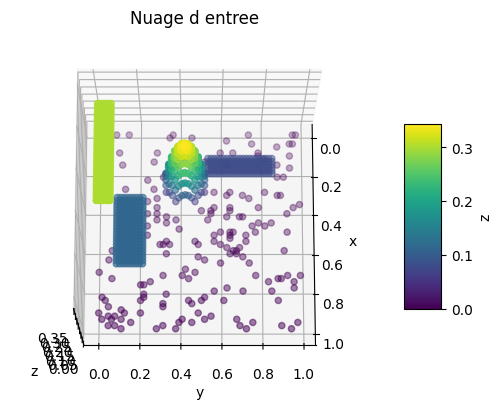

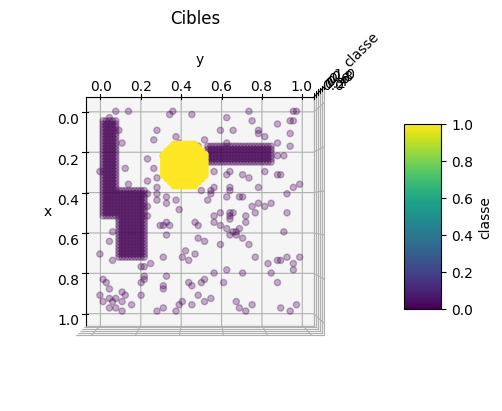

4


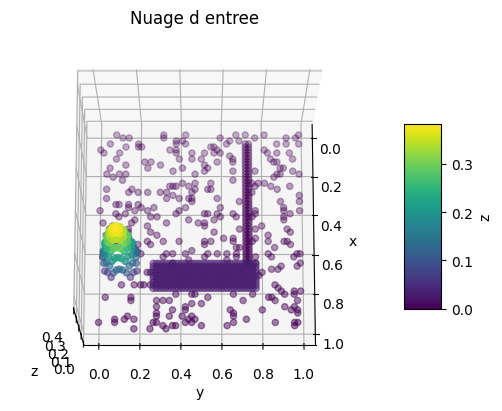

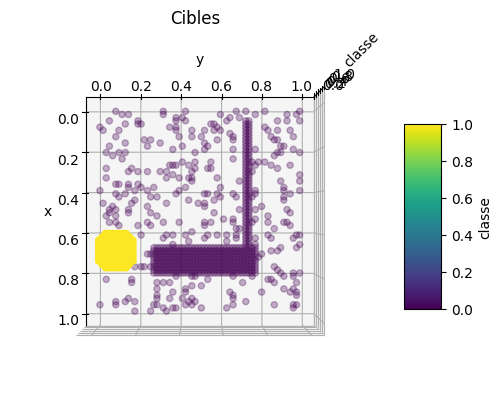

5


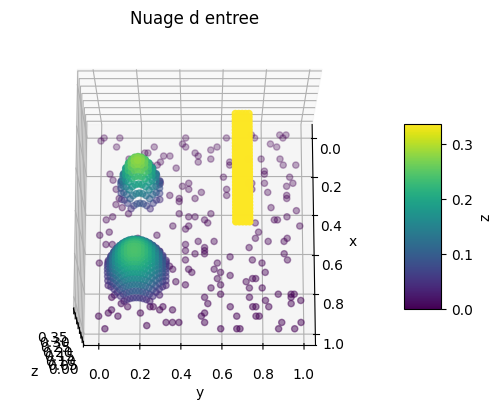

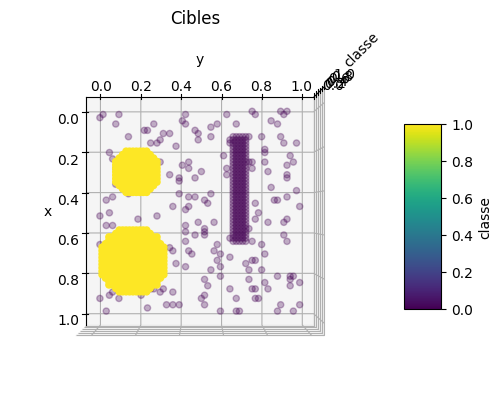

In [2]:
batch_size = 6
input_points, target_list, target_points  = gen_pointcloud(batch_size)


for i in range(batch_size):
  print(i)
  # Représentation 3D des nuages de points et
  # les paramètres elev et azim permettent de changer l'angle de vue
  plot_triplets(input_points[i].transpose(0,1).cpu(),
                elev=75, azim=0)

  # Cibles : les points appartenant aux toitures d'igloos sont
  # dans la classe 1, les autres, dans la classe 0.
  plot_triplets(target_points[i].transpose(0,1).cpu(),
                title='Cibles',
                cbar_label='classe')

  # Note: target_points contient non seulement les classes
  # mais aussi les coordonnées x et y des points, pour
  # faciliter leur visualisation

**Q1** A quoi correspondent les différentes dimensions de *input_points* ?

In [ ]:
# Les dimensions de input_points : (batch_size, n_points, 3)
# batch_size : le nombre de nuages de points dans le lot (batch) dans le code fixed à 6.
# n_points : le nombre de points dans chaque nuage de points déterminée par la fonction gen_pointcloud.
# 3 : les coordonnées (x, y, z) de chaque point dans l'espace 3D.

**Q2** Les points d'un nuage sont-ils rangés dans un ordre particulier ?

In [ ]:
# En regardant la fonction gen_pointcloud, on voit que les point ne sont pas rangés dans un
# ordre spécifique, on a un échantillonange qui est aléatoire basé sur get_random_xy_triplets, puis les
# points collectés dans des listes sont concaténés pour former le tenseur final du nuage de points.

# L'ordre des points n'est pas essentiel pour capturer cette disposition spatiale.

**Q3** (question ouverte). Si vous deviez traiter le problème avec un FCN ou un ViT (Visual Transformer), que feriez-vous ?

In [ ]:
# Pour traiter et adapter ce problème avec FCN et ViT pour la segmentation de nuage de points il faudrait
# tout d'abord trouver une représentation adéquate des données. Pour faire le choix entre les deux
# il faudrait prendre en compte la complexité du jeu et les ressources de calcul disponibles.
# Par exemple pour le FCN l'approche serait de transformer les nuages de points en une grille 3D,
# puis appliquer des convolutions 3D pour extraire les caractéristiques spatiales locales.
# l'avantage de cette méthode est qu'elle est assez bonne pour capturer des relations locales internes
# dans des structures régulières.
# Les limitations est qu'elle peut être coûteuse en mémoire, et que l’ordre des points n’est pas pris en compte.

In [ ]:
# Si on veut traiter avec ViT :
# Approche : Transformer les points en patches ou vecteurs (en traitant chaque point comme un "token"),
# puis appliquer un modèle de transformer pour capturer des relations globales via l'attention.
# Avantages : Efficace pour capturer des relations globales entre les points, sans nécessiter de structure
# régulière. Plus directe et permet de mieux préserver la structure du nuage de points.
#Limitation : Plus coûteux en calcul et nécessite souvent plus de données pour bien fonctionner.

## Partie II : le modèle PointNet

Dans cette partie, on s'intéresse à la propriété principale d'un réseau PointNet : l'utilisation d'opérations invariantes par rapport à l'ordre dans lequel les points sont présentés au réseau.

In [3]:
from utils_probleme2 import PointNetSegHead
pointnet = PointNetSegHead(num_points=800, num_global_feats=1024, m=2).cuda()

input_points, target_list, _ = gen_pointcloud(batch_size)
input_points = input_points.cuda()
output, _, _ = pointnet(input_points)

**Q1** La sortie du modèle PointNet correspond au premier tenseur du *tuple* fourni la fonction *forward* de *pointnet*. A quoi correspondent les différentes dimensions de *output* ? Quel est l'effet d'une permutation des points contenus dans *inputs_points* sur la sortie ? Répondre :

- en vous référant à l'article [l'article](https://arxiv.org/abs/1612.00593) qui introduit ce réseau (citer dans le texte).
- à partir de tests à effectuer dans la cellule de code suivante (utiliser torch.randperm pour générer des permutations sur les entrées)

In [ ]:
# Les dimensions de l'output sont (batch_size, num_points, m)  :
# batch_size : Taille du lot / nombre de points de nuage dans le batch.
# num_points : Nombre de points dans chaque nuage de points (égale à 800).
# m : Nombre de classes pour la segmentation (égale à 2).

# L'effet de permutation des points contenus dans inputs_points sur la sortie:
# Grâce à l'invariance par rapport à l'ordre des points dans l'architecture PointNet
# (via des opérations comme le max pooling, application de la même MLP et utilisation de fonctions symétriques)
#,permuter les points dans input_points n'affecte pas toujours la sortie.

In [24]:
# Generate input points
input_points, _, _ = gen_pointcloud(batch_size)
input_points = input_points.cuda()

# Original output
output_original, _, _ = pointnet(input_points)

# Permute the points within each point cloud
idx = torch.randperm(input_points.shape[1])
permuted_input_points = input_points[:, idx, :]

# Output with permuted input
output_permuted, _, _ = pointnet(permuted_input_points)

# Calculate the difference and maximum difference
diff = torch.abs(output_original - output_permuted)
max_diff = diff.max()

# Tolerance check (using a reasonable tolerance)
tolerance = 1e-6

if max_diff < tolerance:
    print("Outputs are essentially the same within tolerance.")
else:
    print(f"Maximum difference: {max_diff}")

Maximum difference: 6.615017414093018


**Q2** L'architecture de *pointnet* est décrite dans la Figure 2 de l'article (voir ci-dessous) évoqué à la question précédente. En dehors des opérations notées "input transform" et "feature transform", dont la compréhension est plus délicate, quelles sont les différentes opérations conduisant à une segmentation ? Que signifie le terme "shared" et expliquer en quoi ces opérations sont invariantes par rapport à l'ordre de présentation des points.

<img src= https://miro.medium.com/v2/resize:fit:1100/format:webp/1*lFnrIqmV_47iRvQcY3dB7Q.png >

In [ ]:
# 1. Opérations conduisant à la segmentation dans PointNet :

# MLP partagé (Shared MLP) : Chaque point du nuage de points passe à travers le même réseau de neurones (MLP) avec des poids partagés.
# garantissant un traitement équivalent, indépendamment de leur ordre dans le lot.
# Le MLP (64,64) extrait des caractéristiques locales de chaque point du nuage indépendamment.
# Le MLP (64,128,1024) traite ces caractéristiques de manière plus complexe,augmentant la capacité
# de représentation avec des couches supplémentaires.

# Max Pooling : les caractéristiques sont agrégées avec une opération de max pooling.
# Cela prend la valeur maximale sur l'ensemble des points, rendant l'opération invariante
# à l'ordre des points.

# Feature Transform : Une matrice de transformation est appliquée aux caractéristiques pour
# les aligner dans un espace partagé, améliorant ainsi l'apprentissage global des représentations.

# Décision de segmentation : Après l'agrégation des caractéristiques locales et globales,
# des couches entièrement connectées sont utilisées pour classer chaque point,
# obtenant ainsi la segmentation. MLP (512,256,128,m),ce MLP final est appliqué aux caractéristiques
# concaténées pour produire des scores de segmentation par point pour chacun des m sous-catégories sémantiques.

# 2. Signification du terme "shared" :
# Le terme "shared" signifie que le même ensemble de poids est utilisé pour traiter chaque
# point dans le nuage de points, garantissant ainsi que tous les points sont traités de manière identique
#, peu importe l'ordre dans lequel ils sont présentés au réseau.


# 3. Invariance à l'ordre des points :
# L'invariance est obtenue grâce au MLP partagé, où chaque point est traité avec les mêmes poids.
# Le max pooling global est également invariant à l'ordre des points, car il prend les valeurs maximales
# de toutes les caractéristiques des points, indépendamment de l'ordre dans lequel ils sont présentés.
# Donc les opérations dans PointNet, comme using  MLPs partagés et max pooling, garantissent que l'ordre des
# points dans le nuage n'affecte pas le résultat final.


## Partie III

Dans cette partie, on se propose d'entraîner un PointNet. Pour ce faire, on utilisera une fonction de coût spécifique (voir cellule ci-dessous).

**Consignes :**

1) Entraîner un PointNet sur quelques centaines d'époques.

2) Afficher à chaque époque la justesse des prédictions

3) Charger les poids d'un réseau entraîné sur 500 époques, stockés dans le fichier **pointnet_500_ep.pth** du répertoire https://huggingface.co/nanopiero/pointnet_igloos.

Visualiser les sorties de ce modèle-là en complétant le la dernière cellule de code du calepin.


In [ ]:
optimizer = torch.optim.Adam(pointnet.parameters(),
                             lr=0.0001, betas=(0.9, 0.999))

# manually set alpha weights
alpha = np.array([0.2, 0.8])
gamma = 1
loss_fn = PointNetSegLoss(alpha=alpha, gamma=gamma, dice=True).cuda()

# exemple d'utilisation de PointNetSegLoss:
# La transposition permet de repasser la dimension relative
# aux probabilités en dernier, comme avec torch.nn.CrossEntropyLoss
proba_pred_list = outputs.transpose(1,2)
loss_fn(proba_pred_list, target_list)

In [ ]:
batch_size = 64
n_epochs = 200
n_batch_per_epoch = 10


for epoch in range(1, n_epochs):
  print('epoch : ', epoch)
  for batch in range(1,n_batch_per_epoch):
    ...

In [ ]:
input_points, target_list , target_points = gen_pointcloud(6)

# Il faut construire les prédictions.
proba_pred_list, _, _ = pointnet2.cuda()(input_points.to(device))
pred_list = proba_pred_list.transpose(1,2).max(1)[1].cpu()

# Accuracy:
...
# Tracé

for i in range(6):
  print(i)
  plot_triplets(input_points[i].transpose(0,1), elev=75, azim=0)
  plot_triplets(target_points[i].transpose(0,1),
                title='Cibles',
                cbar_label='classe')
  plot_triplets(...,
                title='Predictions',
                cbar_label='classe')
